<a href="https://colab.research.google.com/github/felipe-piano/TCC---SINAIS-DE-VIBRACAO-DE-ROLAMENTOS-COM-VELOCIDADE-VARIAVEL/blob/main/TCC_Felipe_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>SINAIS DE VIBRAÇÃO DE ROLAMENTOS EM VELOCIDADES VARIÁVEL</b>

In [117]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [118]:
# CRIAR LISTAS COM O ROTULOS DOS SINAIS
nome1 = ['H','I','O']
nome2 = ['A','B','C','D']
nome3 = ['1','2','3']
arquivo = []
nome_classe = []
for i in nome1:
  for j in nome2:
    for k in nome3:
      arquivo.append(i+'-'+j+'-'+k)
      nome_classe.append(i+j+k)

In [119]:
# IMPORTAR SINAIS DE VIBRAÇÃO .mat
for i,v in enumerate(arquivo):
  locals()[nome_classe[i]] = loadmat('/content/drive/MyDrive/Sinais de Vibração - Velocidade Variável/'+v+'.mat')['Channel_1'].reshape(2000000)

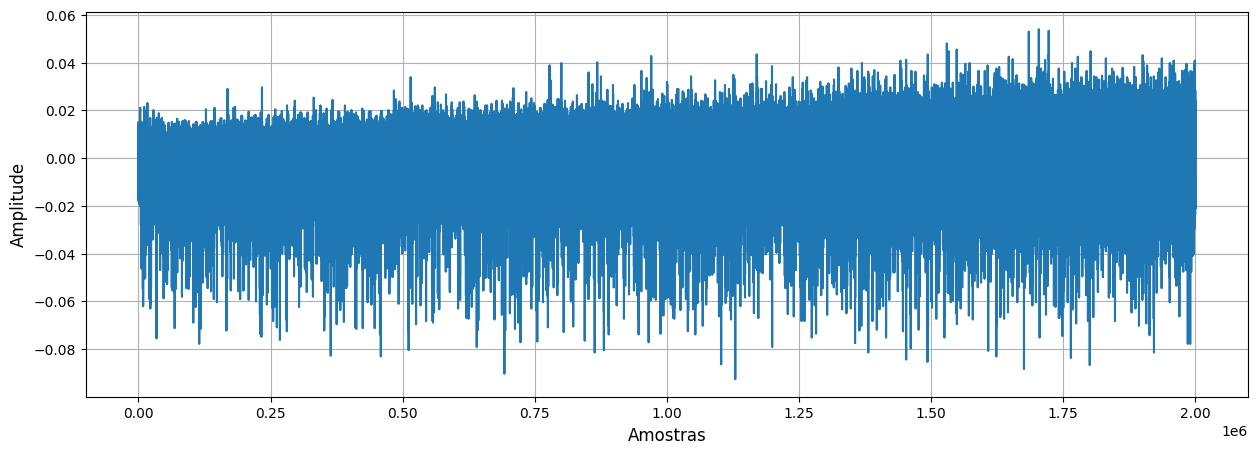

In [120]:
# PLOTAGEM DO SINAL DE VIBRAÇÃO
sinal = HA2
plt.figure(figsize=(15,5))
plt.plot(sinal)
plt.xlabel('Amostras', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid()
plt.show()

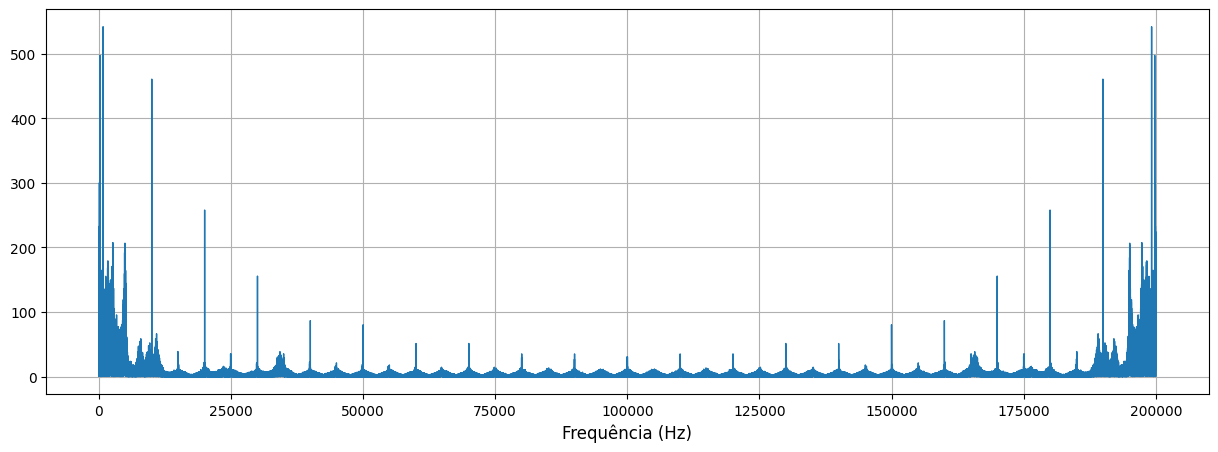

In [121]:
freq_amost = 200e3
freq1 = np.linspace(0, freq_amost, len(sinal))
espec = np.fft.fft(sinal)
plt.figure(figsize=(15,5))
plt.plot(freq1, abs(espec), color='tab:blue', linewidth=1)
plt.xlabel('Frequência (Hz)', fontsize=12)
#plt.title('Espectro da Saída - Sem componente DC', fontsize=14)
plt.grid()
plt.show()

In [122]:
# FUNÇÃO PARA JANELAR O SINAL
def wind(sinal,tamanho,sobreposicao):
    # a recebe o tamanho do sinal.
    a = sinal.size
    # b recebe o tamanho do sinal sem o resto da divisão pelo
    # número de janelas.
    b = a - a%tamanho
    # janela recebe o sinal remodelado, cada linha é uma janela.
    sinal_1 = sinal[0:b]
    janela = [sinal_1[0:tamanho]]
 
    for n in range(1,int(b/(tamanho*(1 - sobreposicao)))-1):
        c = np.floor(n*tamanho*(1 - sobreposicao))
        d = c + tamanho
        janela.append(sinal_1[int(c):int(d)])
        
    janela = np.concatenate([janela],axis=1)
    return janela

In [123]:
# APLICA A FUNÇÃO wind PARA FAZER O JANELAMENTO
tamanho = 1000
# Lista com os sinais.
sinais = [HA1,IA1,OA1]
# Lista que recebe os sinais janelados.
sinais_jan = []
# Laço para janelar todos os sinais.
for n in sinais:
    sinais_jan.append(wind(n,tamanho,0))

In [124]:
# Gera os rótulos de cada classe.
labels = [np.repeat(0,repeats=len(sinais_jan[0]),axis=0),
          np.repeat(1,repeats=len(sinais_jan[1]),axis=0),
          np.repeat(2,repeats=len(sinais_jan[2]),axis=0)]
labels = np.concatenate(labels)

In [125]:
# Labels das classes em codificação one-hot
Y = to_categorical(labels)
# Atributos na forma de array
X = np.concatenate(sinais_jan)
# Dividi os dados aleatoriamente em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.5, random_state=42)
# Adiciona um dimensão a mais para entrar na rede
X_train = np.expand_dims(X_train,axis=2)
X_test = np.expand_dims(X_test,axis=2)

In [126]:
# Convolutional Neural Network
def create_VGG16_1D():
  model = Sequential()
  #Entrada
  model.add(Input(shape=(tamanho,1)))
  # 1ª Bloco
  model.add(Conv1D(filters=16,kernel_size=9, activation='relu',padding='same'))
  model.add(MaxPooling1D(pool_size=4,strides=4,padding='same'))
  # 2ª Bloco
  model.add(Conv1D(filters=16,kernel_size=9, activation='relu',padding='same'))
  model.add(MaxPooling1D(pool_size=4,strides=4,padding='same'))
  # Fully Connected Layer
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  # Compila a rede
  model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
  return model

In [127]:
model = create_VGG16_1D()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1000, 16)          160       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 250, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 250, 16)           2320      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 63, 16)           0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1008)              0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [128]:
# Callbacks
my_callback = EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)
               
# Treinamendo do modelo
model.fit(X_train,Y_train, validation_data=(X_test,Y_test), batch_size=32,
          epochs=10,callbacks = my_callback)

accuracy = model.evaluate(X_test,Y_test,verbose=0)[1]
print('\nAcurácia - dados de validação: %.2f' % (accuracy*100),'%')

Epoch 1/10
94/94 [==============================] - 5s 41ms/step - loss: 0.5442 - accuracy: 0.6724 - val_loss: 0.4569 - val_accuracy: 0.7469
Epoch 2/10
94/94 [==============================] - 5s 54ms/step - loss: 0.4187 - accuracy: 0.7615 - val_loss: 0.3564 - val_accuracy: 0.8143
Epoch 3/10
94/94 [==============================] - 3s 32ms/step - loss: 0.3162 - accuracy: 0.8566 - val_loss: 0.2749 - val_accuracy: 0.8880
Epoch 4/10
94/94 [==============================] - 3s 31ms/step - loss: 0.2447 - accuracy: 0.9009 - val_loss: 0.2175 - val_accuracy: 0.9136
Epoch 5/10
94/94 [==============================] - 4s 38ms/step - loss: 0.1982 - accuracy: 0.9176 - val_loss: 0.1941 - val_accuracy: 0.9243
Epoch 6/10
94/94 [==============================] - 5s 54ms/step - loss: 0.1596 - accuracy: 0.9400 - val_loss: 0.1996 - val_accuracy: 0.9113
Epoch 7/10
94/94 [==============================] - 4s 38ms/step - loss: 0.1134 - accuracy: 0.9580 - val_loss: 0.1183 - val_accuracy: 0.9513
Epoch 8/10
94

In [129]:
#%reset